# 04.02 Eager execution (Linear Regression)

### Import 부분

In [8]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt


import time
import numpy as np

In [2]:
DATA_FILE = 'data/birth_life_2010.txt'

In [9]:
def read_birth_life_data(filename):
    """
    Read in birth_life_2010.txt and return:
    data in the form of NumPy array
    n_samples: number of samples
    """
    text = open(filename, 'r').readlines()[1:]
    data = [line[:-1].split('\t') for line in text]
    births = [float(line[1]) for line in data]
    lifes = [float(line[2]) for line in data]
    data = list(zip(births, lifes))
    n_samples = len(data)
    data = np.asarray(data, dtype=np.float32)
    return data, n_samples

### Eager Execution 실행

In [4]:
# Tensorflow 처음에 호출한다.
tfe.enable_eager_execution()

In [10]:
# 데이터 세트 읽어 오기
data, n_samples = read_birth_life_data(DATA_FILE)
dataset = tf.data.Dataset.from_tensor_slices((data[:,0], data[:,1]))

In [11]:
# 변수 만들기
w = tfe.Variable(0.0)
b = tfe.Variable(0.0)

In [12]:
# 선형 예측을 정의 한다.
def prediction(x):
    return x * w + b

In [13]:
# 손실 함수 정의 (y, y_predicted)
def squared_loss(y, y_predicted):
    return (y - y_predicted) ** 2

In [15]:
def huber_loss(y, y_predicted, m=1.0):
    """Huber loss"""
    t = y - y_predicted
    # eager mode가 동작 되고 있으므로 python가 똑같은 흐름을 갖는다.
    return t ** 2 if tf.abs(t) <= m else m * ( 2 * tf.abs(t) - m)

In [19]:
def train(loss_fn):
    """ regression 모델이 평가 할때 loss_fn 사용한다. """
    print('Training: loss function: '+ loss_fn.__name__)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    # 차별화 할 기능을 정의합니다.
    def loss_for_example(x, y):
        return loss_fn(y, prediction(x))
    # 값을 반환하고 변수의 기울기를 계산한다.
    grad_fn = tfe.implicit_value_and_gradients(loss_for_example)
    start = time.time()
    for epoch in range(100):
        total_loss = 0.0
        for x_i, y_i in tfe.Iterator(dataset):
            loss, gradients = grad_fn(x_i, y_i) # 특이한 구조이다.
            # 옵티마이져가 스텝마다 loss 와 gradients를 가져간다. 그리고 변수를 업데이트 한다.
            optimizer.apply_gradients(gradients)
            total_loss += loss
        if epoch % 10 == 0:
            print('Epoch {0}: {1}'.format(epoch, total_loss / n_samples))
    print('Took: %f seconds' % (time.time() - start))
    print('Eager execution exhibits significant overhead per operation. '
            'As you increase your batch size, the impact of the overhead will '
            'become less noticeable. Eager execution is under active development: '
            'expect performance to increase substantially in the near future!')

In [20]:
train(huber_loss)

Training: loss function: huber_loss
Epoch 0: 106.16918182373047
Epoch 10: 53.64773178100586
Epoch 20: 42.586669921875
Epoch 30: 31.845298767089844
Epoch 40: 21.576385498046875
Epoch 50: 12.379732131958008
Epoch 60: 8.386137962341309
Epoch 70: 7.563107013702393
Epoch 80: 7.398852348327637
Epoch 90: 7.382768630981445
Took: 14.438990 seconds
Eager execution exhibits significant overhead per operation. As you increase your batch size, the impact of the overhead will become less noticeable. Eager execution is under active development: expect performance to increase substantially in the near future!


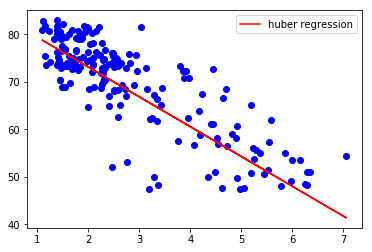

In [21]:
plt.plot(data[:,0], data[:,1], 'bo')
plt.plot(data[:,0], data[:,0] * w.numpy() + b.numpy(), 'r', label="huber regression")
plt.legend()
plt.show()